In [1]:
import copy
import cv2
import joblib
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
from skimage.feature import local_binary_pattern
def lbp_histogram(image, radius, bins):
    # compute the LBP histogram of the image
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp, bins= bins, density=True)
    return np.ravel(hist)

In [3]:
from skimage.feature import hog
# HoG
def hog_(image):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(100, 100),
                	cells_per_block=(2, 2), visualize=True, feature_vector = True)
    return fd

In [4]:
def label_voting(validate_result, image_shape, sliding_window_size, step, image_start):
    height = math.ceil((image_shape[0] - sliding_window_size + 1 - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size + 1 - image_start[1]) / step)
    print(image_shape)
    print([height, width])
    voting = np.zeros((height + 4, width + 4))
    total = np.zeros((height + 4, width + 4))

    for j in range(height):
        for i in range(width):
            if validate_result[i + j * width] == 1:
                voting[j : j + 5, i : i + 5] += np.ones((5, 5))
            total[j : j + 5, i : i + 5] += np.ones((5, 5))
    voting /= total
    voting = np.where(voting > 0.5, 1, 0)

    labeled = []
    for j in range(height):
        for i in range(width):
            sliding_window = [image_start[1] + i * step, image_start[0] + j * step, image_start[1] + (i + 1) * step, image_start[0] + (j + 1) * step]
            if voting[j, i] == 1:
                labeled.append(sliding_window)
    return labeled

In [15]:
def save_labeled_image(image, boxes, file_name='output.jpg'):
    img = copy.deepcopy(image)
    color = np.array([3, 67, 223])
    box_width = 2
    for box in boxes:
        img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * color
        img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * color
        img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * color
        img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * color
    plt.imshow(img)
    plt.imsave(file_name, img)

In [6]:
IMAGE_START = 64
AXIS_ZERO = 121

model_name = "svm_model_layer_classifier.joblib"
model = joblib.load(model_name)
image_path = "../data_preprocessing/processed/WLT_350_210926 P_2111131 WLT_350_210926__008 P_2111131_processed.JPG"

sliding_window_size = 200
step = 40
img = cv2.imread(image_path)

radius = 1
bins = 16

number_image = 0
for j in range(AXIS_ZERO, img.shape[0] - sliding_window_size + 1, step):
    for i in range(IMAGE_START, img.shape[1] - sliding_window_size + 1, step):
        number_image += 1
features=np.zeros(shape=(number_image, bins))

c:\Python310\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
count = 0
for j in range(AXIS_ZERO, img.shape[0] - sliding_window_size + 1, step):
    for i in range(IMAGE_START, img.shape[1] - sliding_window_size + 1, step):
        sliding_window = [i, j, i + sliding_window_size, j + sliding_window_size]
        cropped = img[sliding_window[1]:sliding_window[3], sliding_window[0]:sliding_window[2]]
        rgb_weights = [0.2989, 0.5870, 0.1140]
        cropped = np.dot(cropped[...,:3], rgb_weights)
        cropped = np.array(cropped).astype(np.uint8)
        features[count, :bins] = lbp_histogram(cropped, radius, bins)
        count += 1

In [8]:
# normalize lbp
for i in range(number_image):
    norm = np.linalg.norm(features[i, :bins])
    for j in range(bins):
        features[i, j] = features[i, j] / norm
validate_result = model.predict(features)

print(features.shape)
print(validate_result.shape)

(1265, 16)
(1265,)


(1207, 2463, 3)
[23, 55]


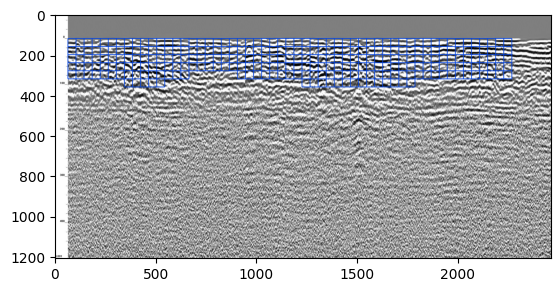

In [16]:
labeled = label_voting(validate_result, img.shape, sliding_window_size, step, [AXIS_ZERO, IMAGE_START])
save_labeled_image(img, labeled, file_name='output_lbp.jpg')

In [10]:
IMAGE_START = 64
AXIS_ZERO = 121

hog_model_name = "random_forest_model_toplayer.joblib"
hog_model = joblib.load(hog_model_name)

number_lbp_image = validate_result[validate_result == 1].shape[0]
hog_features=np.zeros(shape=(number_lbp_image, 36))

c:\Python310\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
count = 0
features_count = 0
for j in range(AXIS_ZERO, img.shape[0] - sliding_window_size + 1, step):
    for i in range(IMAGE_START, img.shape[1] - sliding_window_size + 1, step):
        if validate_result[count] == 1:
            sliding_window = [i, j, i + sliding_window_size, j + sliding_window_size]
            cropped = img[sliding_window[1]:sliding_window[3], sliding_window[0]:sliding_window[2]]
            rgb_weights = [0.2989, 0.5870, 0.1140]
            cropped = np.dot(cropped[...,:3], rgb_weights)
            cropped = np.array(cropped).astype(np.uint8)
            hog_features[features_count] = hog_(cropped)
            features_count += 1
        count += 1

In [12]:
hog_validate_result = hog_model.predict(hog_features)

print(hog_features.shape)
print(hog_validate_result.shape)

(178, 36)
(178,)


In [13]:
height = math.ceil((img.shape[0] - sliding_window_size - AXIS_ZERO) / step)
width = math.ceil((img.shape[1] - sliding_window_size - IMAGE_START) / step)
voting = np.zeros((height + 4, width + 4))
total = np.zeros((height + 4, width + 4))

features_count = 0
for j in range(height):
    for i in range(width):
        if validate_result[i + j * width] == 1:
            if hog_validate_result[features_count] == 1:
                voting[j : j + 5, i : i + 5] += np.ones((5, 5))
            features_count += 1
        total[j : j + 5, i : i + 5] += np.ones((5, 5))

voting /= total
voting = np.where(voting > 0.1, 1, 0)

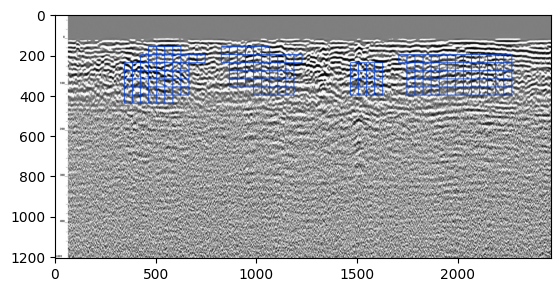

In [14]:
labeled = []
for j in range(height):
    for i in range(width):
        sliding_window = [IMAGE_START + i * step, AXIS_ZERO + j * step, IMAGE_START + (i + 1) * step, AXIS_ZERO + (j + 1) * step]
        if voting[j, i] == 1:
            labeled.append(sliding_window)

image = copy.deepcopy(img)
color = np.array([3, 67, 223])
box_width = 2
for box in labeled:
    image[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(image[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * color
    image[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(image[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * color
    image[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(image[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * color
    image[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(image[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * color
plt.imshow(image)
plt.imsave('output_lbp_hog.jpg', image)